<a href="https://colab.research.google.com/github/Foxyptz/First_project/blob/master/test_task_for_internet_provider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Тестовое задание: Прогнозирование оттока пользователей провайдера телекоммуникационных услуг. 

Датасеты:

log.csv - содержит фичи с поведением пользователя и его обращениями.

named.csv - лог днс запросов к доменам конкурентов (rt.ru (http://rt.ru/) и sampo.ru (http://sampo.ru/)).

type_contract.csv - тип списания у пользователей. 1 - посуточная, 0 - помесячная.

train.csv - выборка для тренировки. 1 - клиент ушел от нас, 0 - остался. 

test.csv - тестовая выборка.

Импортируем библиотеки.

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
try:
    import phik
except ModuleNotFoundError:
    !pip install phik
import phik 

In [ ]:
try:
    import optuna
except ModuleNotFoundError:
    !pip install optuna
import optuna 

Загружаем датасеты и знакомимся с данными.

In [ ]:
logs_df = pd.read_csv("https://drive.google.com/uc?id=193rVq3OG3MRHMEeYNHtt7SsewBNkaeKk", sep='	')

In [ ]:
logs_df.head()

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:31:17,"Включение услуги ""Ограничение функций ТВ"""


In [ ]:
logs_df.duplicated().value_counts()


False    25881
True       550
dtype: int64

550 строк повторяются, удалим их.

In [ ]:
logs_df = logs_df.drop_duplicates()

In [ ]:
logs_df.shape

(25881, 3)

На основе исходного датафрейма с фичами создадим новый, с которым удобнее продолжать работу.

In [ ]:
logs_dummies_df = pd.get_dummies(logs_df[['contract_id','event_type']])
features = logs_dummies_df.columns

In [ ]:
features

Index(['contract_id', 'event_type_Абонент оставил отзыв в Личном кабинете',
       'event_type_Активация ГП с IVR',
       'event_type_Активация автоматического гарантированного платежа',
       'event_type_Активация гарантированного платежа',
       'event_type_Активация точки подключения на сутки',
       'event_type_Без границ бесплатно. Включение',
       'event_type_Без границ бесплатно. Отключение',
       'event_type_Без границ платно. Включение',
       'event_type_Без границ платно. Отключение',
       ...
       'event_type_Турбокнопка платно (1 сутки)',
       'event_type_Турбокнопка платно (1 час)',
       'event_type_Уведомления: отключение',
       'event_type_Уведомления: подключение',
       'event_type_Уведомления: подтверждение',
       'event_type_Удаление ip-адреса',
       'event_type_Удаление из Обращались с номеров',
       'event_type_Удаление телефона из записи',
       'event_type_Футболка Ситилинк',
       'event_type_Чек лист выполненных работ при регистраци

In [ ]:
logs_features = logs_dummies_df.groupby(by='contract_id').sum()

In [ ]:
logs_features.head()

,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Включение,event_type_Без границ бесплатно. Отключение,event_type_Без границ платно. Включение,event_type_Без границ платно. Отключение,event_type_Блокировка,...,event_type_Турбокнопка платно (1 сутки),event_type_Турбокнопка платно (1 час),event_type_Уведомления: отключение,event_type_Уведомления: подключение,event_type_Уведомления: подтверждение,event_type_Удаление ip-адреса,event_type_Удаление из Обращались с номеров,event_type_Удаление телефона из записи,event_type_Футболка Ситилинк,event_type_Чек лист выполненных работ при регистрации
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

logs_features.describe()

,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Включение,event_type_Без границ бесплатно. Отключение,event_type_Без границ платно. Включение,event_type_Без границ платно. Отключение,event_type_Блокировка,...,event_type_Турбокнопка платно (1 сутки),event_type_Турбокнопка платно (1 час),event_type_Уведомления: отключение,event_type_Уведомления: подключение,event_type_Уведомления: подтверждение,event_type_Удаление ip-адреса,event_type_Удаление из Обращались с номеров,event_type_Удаление телефона из записи,event_type_Футболка Ситилинк,event_type_Чек лист выполненных работ при регистрации
count,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,...,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000,4379.000000
mean,0.019639,0.017812,0.001827,0.023065,0.016214,0.012332,0.011646,0.003882,0.003197,0.001370,...,0.019411,0.021466,0.002740,0.004796,0.003197,0.000457,0.010961,0.004567,0.000228,0.000685
std,0.155830,0.222434,0.052322,0.277309,0.144843,0.392173,0.406212,0.075467,0.070816,0.036995,...,0.318226,0.266091,0.060391,0.081247,0.056459,0.030223,0.146119,0.082653,0.015112,0.026168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,8.000000,2.000000,11.000000,2.000000,25.000000,26.000000,3.000000,3.000000,1.000000,...,14.000000,7.000000,2.000000,3.000000,1.000000,2.000000,5.000000,3.000000,1.000000,1.000000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
named_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ситилинк/Data/named.csv', sep = '	')

In [ ]:
named_df.shape

(10646537, 3)

In [ ]:
named_df.head()

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335
3,17-Apr-2021,tvip-provision.sampo.ru,61670
4,17-Apr-2021,tvip-provision.sampo.ru,39370


In [ ]:
named_df['url'].value_counts()

camera.rt.ru                                         7333195
vmxott.svc.iptv.rt.ru                                 289876
tvip-provision.sampo.ru                               138944
webmail.sampo.ru                                      132718
statserv.sampo.ru                                     110428
                                                      ...   
_bittorrent-tracker._tcp.ip94-143-246-20.sampo.ru          1
_bittorrent-tracker._tcp.ip212-109-29-44.sampo.ru          1
jcyzowodsk.sampo.ru                                        1
dhmisszt.sampo.ru                                          1
broadband-90-154-70-112.ip.moscow.rt.ru                    1
Name: url, Length: 6583, dtype: int64

В логфайле с адресами конкурентов проведем работу, уберем цифры из адресов и т.д.

In [ ]:
named_df[named_df['url'].str.contains(r'^(?=.*bittorrent-tracker)(?=.*sampo.ru)')] = 'bittorrent-tracker.sampo.ru'

In [ ]:
value_counts = named_df['url'].value_counts().to_frame()
value_counts = value_counts.reset_index()
value_counts.columns = ['url', 'cnt']
value_counts[(value_counts.cnt > 2000)] #& (value_counts.url.str.match('.*rt\.ru'))]
value_counts


,url,cnt
0,camera.rt.ru,7333195
1,vmxott.svc.iptv.rt.ru,289876
2,tvip-provision.sampo.ru,138944
3,webmail.sampo.ru,132718
4,statserv.sampo.ru,110428
...,...,...
6487,nnhvcdnjukbhmkr.sampo.ru,1
6488,pifqsuiuyo.sampo.ru,1
6489,dns.google.com.sampo.ru,1
6490,tgjjvaapvybgnhw.sampo.ru,1


In [ ]:
def remove_ip(s):
  return re.sub(
            r"\b\d{1,3}[\.,-]\d{1,3}[\.,-]\d{1,3}[\.,-]\d{1,3}\b", 
            'x',
            s
        )
  
def remove_n(s):
  return re.sub(
            '[0-9]', 
            '',
            s
        )
  
def speedtest(s):
    return re.sub(
            r'(\w*\.)(speedtest\.rt\.ru)', 
            r'\2',
            s
        )
    
def iptv(s):
    return re.sub(
            r'(.*\.)(iptv\.rt\.ru)', 
            r'\2',
            s
        )

def sampo_ru(s):
    return re.sub(
            r'(!cat.*)(\.sampo\.ru)', 
            r'\2',
            s
        )
  
print(remove_ip('broadband-90-154-70-112.ip.moscow.rt.ru'))
print(remove_ip('ppp-5.137.119.94.nsk.rt.ru'))
print(remove_ip('tgjjvaapvybgnhw.sampo.ru'))
print(remove_n('643378.16.rt.ru'))
print(speedtest('orel.speedtest.rt.ru'))
print(iptv('vmxott.svc.iptv.rt.ru'))
print(iptv('sib-irkt-itv.svc.iptv.rt.ru'))
print(sampo_ru('xzeyncp.sampo.ru'))


named_df['url'] = named_df['url'].apply(remove_n)
named_df['url'] = named_df['url'].apply(speedtest)
named_df['url'] = named_df['url'].apply(iptv)

broadband-x.ip.moscow.rt.ru
ppp-x.nsk.rt.ru
tgjjvaapvybgnhw.sampo.ru
..rt.ru
speedtest.rt.ru
iptv.rt.ru
iptv.rt.ru
xzeyncp.sampo.ru


In [ ]:
def add_replacer(match_obj):
    return str(int(match_obj.group(1)) + int(match_obj.group(2)))

def eval_adds(string):
    return re.sub("(\d|[1-9]\d+)\s*\+\s*(\d|[0-9]\d+)", add_replacer, string)

print(eval_adds("the result is 5 + 4."))

the result is 9.


Отберем 100 наиболее часто встречающихся в логе адресов.

In [ ]:
named_often = named_df['url'].value_counts().head(100)

In [ ]:
named_often.index

Index(['camera.rt.ru', 'iptv.rt.ru', '..rt.ru', '_sip._udp...rt.ru',
       'st-broadcast.sampo.ru', '_sip._tcp...rt.ru', 'tvip-provision.sampo.ru',
       'webmail.sampo.ru', 'statserv.sampo.ru', 'navigator.sampo.ru',
       'storage.swap.sampo.ru', 'fnc.rt.ru', 'moigorod.sampo.ru',
       'swap.sampo.ru', 'acs.rt.ru', 'sampo.ru', 'lk.sampo.ru',
       'ohrana.sampo.ru', 'vhod.sampo.ru', 'mail.sampo.ru', 'sus.sampo.ru',
       'camera-updater.camera.rt.ru', 'vitrina.sampo.ru', 'data.sampo.ru',
       'profile.sampo.ru', 'karelia.rt.ru', 'games.sampo.ru', 'kino.sampo.ru',
       'radio.sampo.ru', 'start.sampo.ru', 'kino.swap.sampo.ru',
       'speedtest.rt.ru', 'cctv.sampo.ru', 'af.rt.ru', 'acs.cloudpbx.rt.ru',
       'rupor.sampo.ru', 'chat.sampo.ru', 'pay.sampo.ru',
       'portal.capsule.nw.rt.ru', 'isatap.sampo.ru', 'mx.sampo.ru',
       'mlk.rt.ru', 'iptv.sampo.ru', 'speedtest.sampo.ru', 'avdesk.sampo.ru',
       'hosting.sampo.ru', 'smotri.sampo.ru', 'wpad.bify.rt.ru',
       'de

In [ ]:
named_df_short = named_df[named_df['url'].isin(named_often.index)]

In [ ]:
named_df_short['url'].value_counts()

camera.rt.ru              7333195
iptv.rt.ru                 739605
..rt.ru                    459230
_sip._udp...rt.ru          264925
st-broadcast.sampo.ru      167508
                           ...   
upay.pay.rt.ru               1346
static.rupor.sampo.ru        1335
.vpbx.sampo.ru               1280
www.sampo.ru                 1278
media-msk.camera.rt.ru       1180
Name: url, Length: 100, dtype: int64

Создадим сводную таблицу - сколько раз каждый пользователь заходил на адрес из 100 самых частых.

In [ ]:
piv_t_named = pd.pivot_table(named_df_short,
               index='contract_id',
               values='url',
               columns = 'url',
               fill_value = 0,
               aggfunc = 'count')

In [ ]:
piv_t_named.head()

url,..rt.ru,.vpbx.sampo.ru,_adsp._domainkey.sampo.ru,_ldap._tcp.dc._msdcs.sz.rt.ru,_sip._tcp...rt.ru,_sip._udp...rt.ru,acs.cloudpbx.rt.ru,acs.rt.ru,adengine.old.rt.ru,af.rt.ru,...,upay.pay.rt.ru,vhod.sampo.ru,vitrina.sampo.ru,webmail.sampo.ru,wifi.sampo.ru,wink.rt.ru,wpad.bify.rt.ru,wpad.sz.rt.ru,www.rt.ru,www.sampo.ru
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,0,0,0,0,0,0,0,0,0,0,...,0,1,3,24,3,0,0,0,0,0
7785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
type_contract_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ситилинк/Data/type_contract.csv', sep = ';')

In [ ]:
type_contract_df.head()

,contract_id,day_or_month_contract
0,7780,0
1,7784,0
2,7785,0
3,7794,0
4,7795,1


In [ ]:
type_contract_df['contract_id'].value_counts() # повтор id

9777      4
8188      2
38532     2
48802     1
48857     1
         ..
29894     1
29892     1
29887     1
29886     1
281551    1
Name: contract_id, Length: 6800, dtype: int64

In [ ]:
type_contract_df.query('contract_id == 38532')

,contract_id,day_or_month_contract
3199,38532,0
3200,38532,0


In [ ]:
type_contract_df = type_contract_df.drop_duplicates().reset_index(drop = True)

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ситилинк/Data/train.csv', sep = ';')

In [ ]:
train_df.head()

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0


In [ ]:
train_df['contract_id'].value_counts() # повтор id

9777      2
38532     2
7780      1
49547     1
49536     1
         ..
30797     1
30792     1
30790     1
30788     1
274918    1
Name: contract_id, Length: 5992, dtype: int64

In [ ]:
train_df = train_df.drop_duplicates().reset_index(drop = True)

In [ ]:
print(train_df[train_df['blocked'] == 1].shape[0])
print(train_df[train_df['blocked'] == 0].shape[0])

698
5294


Имеем дело с дисбалансом классов, число пользователей, которые ушли значительно меньше числа оставшихся пользователей.


Создаем итоговый датафрейм.

In [ ]:
data = train_df.merge(type_contract_df, how = 'inner', on = 'contract_id')

In [ ]:
data.shape

(5992, 3)

In [ ]:
data = data.merge(logs_features, how = 'inner', left_on = 'contract_id', right_on = logs_features.index) # here was left

In [ ]:
data.shape

(3873, 116)

In [ ]:
data.head()

,contract_id,blocked,day_or_month_contract,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Включение,event_type_Без границ бесплатно. Отключение,...,event_type_Турбокнопка платно (1 сутки),event_type_Турбокнопка платно (1 час),event_type_Уведомления: отключение,event_type_Уведомления: подключение,event_type_Уведомления: подтверждение,event_type_Удаление ip-адреса,event_type_Удаление из Обращались с номеров,event_type_Удаление телефона из записи,event_type_Футболка Ситилинк,event_type_Чек лист выполненных работ при регистрации
0,7780,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7785,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7795,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7798,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7805,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = data.merge(piv_t_named, how = 'left', left_on = 'contract_id', right_on = piv_t_named.index)

In [ ]:
data.head()

,contract_id,blocked,day_or_month_contract,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Включение,event_type_Без границ бесплатно. Отключение,...,upay.pay.rt.ru,vhod.sampo.ru,vitrina.sampo.ru,webmail.sampo.ru,wifi.sampo.ru,wink.rt.ru,wpad.bify.rt.ru,wpad.sz.rt.ru,www.rt.ru,www.sampo.ru
0,7780,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,24.0,3.0,0.0,0.0,0.0,0.0,0.0
1,7785,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7795,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7798,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7805,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Заполним пропуски значений нулями.

In [ ]:
data = data.fillna(0)
data.shape

(3873, 216)

In [ ]:
data.isna().sum()

contract_id                                           0
blocked                                               0
day_or_month_contract                                 0
event_type_Абонент оставил отзыв в Личном кабинете    0
event_type_Активация ГП с IVR                         0
                                                     ..
wink.rt.ru                                            0
wpad.bify.rt.ru                                       0
wpad.sz.rt.ru                                         0
www.rt.ru                                             0
www.sampo.ru                                          0
Length: 216, dtype: int64

In [ ]:
data.columns

Index(['contract_id', 'blocked', 'day_or_month_contract',
       'event_type_Абонент оставил отзыв в Личном кабинете',
       'event_type_Активация ГП с IVR',
       'event_type_Активация автоматического гарантированного платежа',
       'event_type_Активация гарантированного платежа',
       'event_type_Активация точки подключения на сутки',
       'event_type_Без границ бесплатно. Включение',
       'event_type_Без границ бесплатно. Отключение',
       ...
       'upay.pay.rt.ru', 'vhod.sampo.ru', 'vitrina.sampo.ru',
       'webmail.sampo.ru', 'wifi.sampo.ru', 'wink.rt.ru', 'wpad.bify.rt.ru',
       'wpad.sz.rt.ru', 'www.rt.ru', 'www.sampo.ru'],
      dtype='object', length=216)

Посмотрим как коррелируют между собой получившиеся признаки.

In [ ]:
data.drop(['contract_id', 'blocked'], axis = 1).corr()

,day_or_month_contract,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Включение,event_type_Без границ бесплатно. Отключение,event_type_Без границ платно. Включение,event_type_Без границ платно. Отключение,...,upay.pay.rt.ru,vhod.sampo.ru,vitrina.sampo.ru,webmail.sampo.ru,wifi.sampo.ru,wink.rt.ru,wpad.bify.rt.ru,wpad.sz.rt.ru,www.rt.ru,www.sampo.ru
day_or_month_contract,1.000000,0.031574,0.046962,0.022186,0.027474,-0.004201,0.015311,0.014699,0.008160,0.018558,...,-0.028290,-0.015403,-0.018218,-0.013256,-0.023035,-0.012672,-0.014614,-0.014614,-0.002317,-0.016187
event_type_Абонент оставил отзыв в Личном кабинете,0.031574,1.000000,-0.002073,-0.004385,-0.004041,0.058034,0.012954,0.020286,0.037894,0.018400,...,0.012432,-0.003840,-0.004060,-0.000694,0.015952,0.001025,-0.001898,-0.001898,0.006367,-0.002564
event_type_Активация ГП с IVR,0.046962,-0.002073,1.000000,0.117895,0.242973,-0.008625,-0.002290,-0.002198,-0.004003,-0.003433,...,-0.005528,-0.005128,-0.003320,-0.002214,-0.007066,-0.003879,-0.001278,-0.001278,-0.004198,-0.001728
event_type_Активация автоматического гарантированного платежа,0.022186,-0.004385,0.117895,1.000000,0.235543,-0.004026,-0.001069,-0.001026,-0.001869,-0.001603,...,-0.002581,-0.003709,-0.002200,0.000040,-0.004467,-0.002161,-0.000597,-0.000597,-0.001960,-0.000806
event_type_Активация гарантированного платежа,0.027474,-0.004041,0.242973,0.235543,1.000000,0.003368,-0.002394,-0.002299,-0.004186,-0.003590,...,-0.005781,-0.006779,-0.004268,-0.002065,-0.010007,-0.004840,-0.001337,-0.001337,-0.004390,-0.001807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wink.rt.ru,-0.012672,0.001025,-0.003879,-0.002161,-0.004840,-0.006308,-0.001675,-0.001608,-0.002928,-0.002511,...,-0.004044,0.006754,0.003850,0.000394,0.013256,1.000000,-0.000935,-0.000935,0.001476,-0.000967
wpad.bify.rt.ru,-0.014614,-0.001898,-0.001278,-0.000597,-0.001337,-0.001742,-0.000463,-0.000444,-0.000809,-0.000694,...,-0.001117,-0.001605,-0.000952,-0.000542,-0.001933,-0.000935,1.000000,1.000000,-0.000848,-0.000349
wpad.sz.rt.ru,-0.014614,-0.001898,-0.001278,-0.000597,-0.001337,-0.001742,-0.000463,-0.000444,-0.000809,-0.000694,...,-0.001117,-0.001605,-0.000952,-0.000542,-0.001933,-0.000935,1.000000,1.000000,-0.000848,-0.000349
www.rt.ru,-0.002317,0.006367,-0.004198,-0.001960,-0.004390,-0.005722,-0.000781,-0.001458,-0.002656,-0.002278,...,-0.003668,0.000392,0.000078,-0.000338,0.004991,0.001476,-0.000848,-0.000848,1.000000,-0.000798


Удалим признаки, коррелирующие между собой.

In [ ]:
from  itertools import combinations

corr = data.drop(['contract_id', 'blocked'], axis = 1).corr()
#corr.sort_values(ascending=True, inplace=True)
columns_above_90 = [(col1, col2, corr.loc[col1,col2]) for col1, col2 in list(combinations(corr.columns,2)) if abs(corr.loc[col1,col2]) > 0.9 and col1 != col2]
correlat = [col1 for col1, col2 in list(combinations(corr.columns,2)) if abs(corr.loc[col1,col2]) > 0.9 and col1 != col2]

In [ ]:
uni_correlat = pd.Series(correlat).unique()

In [ ]:
for c in uni_correlat:
  data = data.drop(c, axis = 1)

In [ ]:
#data.drop(['contract_id', 'blocked'], axis = 1).phik_matrix()

In [ ]:
#sns.set(rc = {'figure.figsize':(30,16)})
#sns.heatmap(data.drop(['contract_id', 'blocked'], axis = 1).phik_matrix());

Определим тренировочную и тестовую выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['blocked', 'contract_id'], axis = 1), data['blocked'], test_size=0.33, random_state=42)

In [ ]:
X_train.head()

,day_or_month_contract,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Отключение,event_type_Без границ платно. Включение,event_type_Без границ платно. Отключение,event_type_Блокировка,...,tvip-provision.sampo.ru,upay.pay.rt.ru,vhod.sampo.ru,vitrina.sampo.ru,webmail.sampo.ru,wifi.sampo.ru,wink.rt.ru,wpad.sz.rt.ru,www.rt.ru,www.sampo.ru
801,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2329,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1659,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1656,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(2594, 179)
(2594,)
(1279, 179)
(1279,)


In [ ]:
#scaler = StandardScaler()
#X_train_sc = scaler.fit_transform(X_train)
#X_test_sc = scaler.transform(X_test)

Логистическая регрессия.

In [ ]:
model = LogisticRegression(random_state=42, max_iter = 1500, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1500, random_state=42)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
#print(roc_auc_score(y_test, model.decision_function(X_test_sc)))

0.7290849350264342


In [ ]:
confusion_matrix(y_test, predictions)

array([[786, 308],
       [ 67, 118]])

В данной задаче мы предсказываем отток, т.е. положительный класс, в этом случае для оценки модели хорошо подходит метрика площадь под кривой ROC-AUC. Полученное значение 0.73 несомненно можно улучшить, углубив EDA, но даже сейчас, глядя на матроицу ошибок, мы видим, что результат неплохой. Модель неправильно предсказывает уходящих клиентов лишь в 67 случаях, а для 308 клиентов она говорит, что они уйдут, хотя они останутся. Если допустить, что для клиентов, которых модель оценила как поенциально готовых уйти, компания предложит 10 долл. дисконт, а с настоящим уходом потеряет 100 долл. ежемесячно, то в первый месяц согласно модели компания потратит из-за ошибок 3080 долл. на лояльных клиентов и потеряет 6700 долл. на реально ушедших. Поэтому ошибочное предсказание ухода клиентов в случае если клиент лоялен несет в себе меньшие потери, если компания решится на шаги для повышения его лояльности.

[('event_type_Отключение услуги Автоплатёж', 1.8904880617177449),
 ('event_type_Перенос денежных средств', 1.640223781072555),
 ('event_type_Блокировка', 1.5962058451065155),
 ('rt.ru', -1.5118603850959387),
 ('event_type_Отключение услуги Аренда ТВ-приставки', 1.4935038841408377),
 ('event_type_Предложение ТВ-пакета', -1.3758819533826454),
 ('event_type_Предложение автоплатежа', -1.2237074048527603),
 ('event_type_Включена рассрочка за "Wi-Fi маршрутизатор 2.4 ГГц - TP-LINK WR-850N или аналог"',
  1.2207015474838596),
 ('event_type_Добавление в Обращались с номеров', 1.1793249187510684),
 ('event_type_Смена следующего тарифа', -1.1198531867710435),
 ('event_type_Включена 10% скидка', -1.099457540652397),
 ('event_type_Внутреннее сообщение', 1.072441847172284),
 ('event_type_Активация ГП с IVR', -1.0669525989302577),
 ('event_type_Получение подарка в ЛК: сутки интернета на максимальной скорости',
  1.0609176490272934),
 ('ppk.sampo.ru', -1.054645645356872),
 ('vitrina.sampo.ru', -1.041

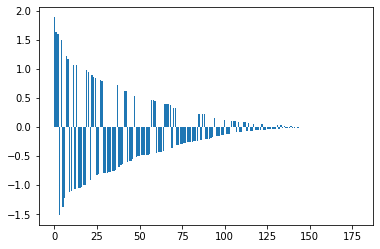

In [ ]:
# get importance
importance = model.coef_[0]

# summarize feature importance
sorted_features = sorted([(X_train.columns[i], v) for i,v in enumerate(importance)], key=lambda t: abs(t[1]), reverse = True)

#for i,v in enumerate(importance):
#	print('Feature: %s, Score: %.5f' % (X_train.columns[i], v)) #(i,v))

display(sorted_features)
# plot feature importance
plt.bar([x for x in range(len(importance))], [i for f,i in sorted_features])
plt.show()


Логистическая регрессия с подбором параметров.

In [ ]:
def log_reg(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
        'random_state': 42,
        'solver': 'liblinear',
        'penalty': 'l1',
        'C': trial.suggest_loguniform('C', 1e-9, 3)
    }
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = LogisticRegression(**params)      
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    #Смотрим финальную метрику
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    return roc_auc

In [ ]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize')  
study.optimize(log_reg, n_trials=35)         # Количество итераций = 

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2022-11-28 08:34:25,093] A new study created in memory with name: no-name-de890270-322b-479d-a9a4-52418a486f13
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
[I 2022-11-28 08:34:25,125] Trial 0 finished with value: 0.5 and parameters: {'C': 1.28885203033481e-09}. Best is trial 0 with value: 0.5.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
[I 2022-11-28 08:34:25,166] Trial 1 finished with value: 0.745879243045605 and parameters: {'C': 0.5591627444257915}. Best is trial 1 with value: 0.745879243

Number of finished trials: 35
Best trial: {'C': 0.4211565824335964}
Best score: 0.7459163002124611


In [ ]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.4211565824335964, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.7459163002124611


In [ ]:
confusion_matrix(y_test, predictions)

array([[1071,   23],
       [ 166,   19]])

Здесь получилось предсказание точнее.

Решающее дерево с подбором параметров.

In [ ]:
def objective_tree(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
        'random_state': 42,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 302, step=10),
        'ccp_alpha': trial.suggest_loguniform('ccp_alpha', 1e-9, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 322, step=20)
    }
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = DecisionTreeClassifier(**params)      
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    #Смотрим финальную метрику
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    return roc_auc

In [ ]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize')  
study.optimize(objective_tree, n_trials=45)         # Количество итераций = 

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2022-11-28 08:34:50,792] A new study created in memory with name: no-name-8f6cb55d-8585-45bb-afd9-d10b92a6e010
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
[I 2022-11-28 08:34:50,823] Trial 0 finished with value: 0.687949009338406 and parameters: {'min_samples_leaf': 152, 'ccp_alpha': 1.3203618212116523e-06, 'max_depth': 222}. Best is trial 0 with value: 0.687949009338406.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
[I 2022-11-28 08:34:50,850] Trial 1 finished with value: 0.6839641286624834 and parameters: {'mi

Number of finished trials: 45
Best trial: {'min_samples_leaf': 52, 'ccp_alpha': 0.0004600751802286068, 'max_depth': 102}
Best score: 0.7601141360739168


In [ ]:
model = DecisionTreeClassifier(min_samples_leaf=52, ccp_alpha=0.0004600751802286068, max_depth=102, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.7601141360739168


In [ ]:
confusion_matrix(y_test, predictions)

array([[1081,   13],
       [ 167,   18]])

Пожалуй, это предсказание наиболее точное.

Для этой модели также можно оценить важность признаков для обучения и в дальнейшем оставить только те, которые действительно важны, т.к. на примере логистической регрессии выше было видно, что ряд признаков не имеют ценности.

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ситилинк/Data/test.csv', sep = ';')

In [ ]:
test_df.head()

,contract_id,blocked
0,275109,NaN
1,275285,NaN
2,275308,NaN
3,275409,NaN
4,275628,NaN


In [ ]:
test_data = test_df.merge(type_contract_df, how = 'left', on = 'contract_id')

In [ ]:
test_data = test_data.merge(logs_features, how = 'left', left_on = 'contract_id', right_on = logs_features.index)

In [ ]:
test_data = test_data.merge(piv_t_named, how = 'left', left_on = 'contract_id', right_on = piv_t_named.index)

In [ ]:
test_data.head()

,contract_id,blocked,day_or_month_contract,event_type_Абонент оставил отзыв в Личном кабинете,event_type_Активация ГП с IVR,event_type_Активация автоматического гарантированного платежа,event_type_Активация гарантированного платежа,event_type_Активация точки подключения на сутки,event_type_Без границ бесплатно. Включение,event_type_Без границ бесплатно. Отключение,...,upay.pay.rt.ru,vhod.sampo.ru,vitrina.sampo.ru,webmail.sampo.ru,wifi.sampo.ru,wink.rt.ru,wpad.bify.rt.ru,wpad.sz.rt.ru,www.rt.ru,www.sampo.ru
0,275109,NaN,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,275285,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275308,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0
3,275409,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,275628,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_data = test_data.fillna(0)

In [ ]:
test_data.isna().sum()

contract_id                                           0
blocked                                               0
day_or_month_contract                                 0
event_type_Абонент оставил отзыв в Личном кабинете    0
event_type_Активация ГП с IVR                         0
                                                     ..
wink.rt.ru                                            0
wpad.bify.rt.ru                                       0
wpad.sz.rt.ru                                         0
www.rt.ru                                             0
www.sampo.ru                                          0
Length: 216, dtype: int64

In [ ]:
for c in uni_correlat:
  test_data = test_data.drop(c, axis = 1)

Ищем предсказание с использованием последней модели.

In [ ]:
test_predictions = model.predict(test_data.drop(['contract_id',	'blocked'], axis = 1))


In [ ]:
test_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import csv
with open('test_1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for s in 
    writer.writerows(someiterable)

In [ ]:
submission = pd.DataFrame()
submission['contract_id'] = test_data['contract_id']
submission['blocked'] = pd.Series(test_predictions) # [:,1])
display(submission.head(17))
submission.shape

,contract_id,blocked
0,275109,0
1,275285,0
2,275308,0
3,275409,0
4,275628,0
5,275684,0
6,275744,0
7,275931,0
8,275947,0
9,276027,0


(811, 2)

In [ ]:
submission.to_csv('!!!test.csv', index=False)